<a href="https://colab.research.google.com/github/jeremychia/singapore-parliament-speeches/blob/main/Parliamentary_Data_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# install bigquery client library
!pip install google-cloud-bigquery --quiet

In [23]:
# authenticate to GCP
from google.colab import auth
auth.authenticate_user()

In [24]:
# set up project id and dataset
project_id = "singapore-parliament-speeches"  # Replace with your GCP project ID
dataset_id = "singapore-parliament-speeches.prod_mart.mart_speeches"

In [25]:
# create a bigquery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [26]:
# define query
query = f"""
  select
    topic_id,
    speech_text
  from {dataset_id}
  order by date desc, speech_id
"""

In [27]:
# run query
import pandas as pd
query_job = client.query(query)
df = query_job.to_dataframe()

In [28]:
# compbine text by topic

def combine_text_by_topic(df):

  combined_text = {}
  for index, row in df.iterrows():
    topic_id = row['topic_id']
    text = row['speech_text']
    if topic_id not in combined_text:
      combined_text[topic_id] = ""
    combined_text[topic_id] += ' ' + text

  result_df = pd.DataFrame.from_dict(combined_text, orient='index', columns=['speech_text'])
  result_df.reset_index(inplace=True)
  result_df.rename(columns={'index': 'topic_id'}, inplace=True)

  return result_df

# execute
ct_df = combine_text_by_topic(df)

In [29]:
ct_df.head()

,topic_id,speech_text
0,2024-03-07-T-001,"Order. Sir, can I ask you to exercise your po..."
1,2024-03-07-T-002,asked the Minister for Defence (a) what effor...
2,2024-03-07-T-003,asked the Minister for Health (a) what is the...
3,2024-03-07-T-004,asked the Minister for Health (a) how many ne...
4,2024-03-07-T-005,asked the Minister for Manpower in view that ...


In [30]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# text preprocessing functions
def lowercase_text(text):
  return text.lower()

def remove_punctuation(text):
  punctuation = string.punctuation
  return "".join([char for char in text if char not in punctuation])

def remove_stopwords(text, custom_stopwords=[]):
  stopword_list = stopwords.words('english')
  stopword_list.extend(custom_stopwords)

  words = [word for word in text.split() if word not in stopword_list]
  return " ".join(words)

def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in text.split()]
  return " ".join(words)

def clean_text(text):
  cleaned_text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
  cleaned_text = re.sub(r"\d+", "", cleaned_text)  # Remove numbers
  cleaned_text = re.sub(r"\s+", " ", cleaned_text)  # Replace multiple spaces with a single space
  cleaned_text = re.sub(r"\n|\t|\r|\f", "", cleaned_text)  # Remove newlines, tabs, carriage returns, and form feeds
  return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The following stop words are removed.

Stopwords, comprising common words like "and," "the," and "is," are typically removed in text analysis tasks for their high frequency and low semantic value. This removal reduces data noise, lowers dimensionality, and improves model performance by focusing on more meaningful terms. Moreover, excluding stopwords enhances interpretability and normalization of text data, aiding in more efficient and effective text analysis and modeling processes.

| Category                     | Stopwords                                         |
|------------------------------|---------------------------------------------------|
| Government and Political     | parliament, ministry, minister, parliamentary,   |
|                              | mr, speaker, member, deputy, indranee, rajah,    |
|                              | zaqy, mohamad, yien, hai, fu, grace, leader,    |
|                              | house                                             |
| Terms                        |                                                   |
| General Stopwords            | also, year, time, need, new, would, one, may,   |
|                              | many, like, whether, u, make, public, take,      |
|                              | well, even, example, text, sitting, act,         |
|                              | edition, read, printed, adjourned, adjourn,      |
|                              | resolved, order, assent, proceeding, chapter,     |
|                              | revised, amend, presented, second, available,    |
|                              | amendment, consequential, state, debate,        |
|                              | tomorrow, resumption, day, beg, fixed, stand,    |
|                              | date, today, accordingly, sit, exempted,         |
|                              | provision, present, general, paper, item,        |
|                              | today, allotted, supply, committee,              |
|                              | consideration, th, nd, rd, pursuant, minute,     |
|                              | pm, rising, speech, respect, discussion,         |
|                              | agreed, january, february, march, april,        |
|                              | may, june, july, august, september, october,    |
|                              | november, december, fy, leave, progress,        |
|                              | chair, head, said                                |
| Specific Terms and Names     | bill, first, question, continue, must, ensure,   |
|                              | proc, amendment, consequential, debate,         |
|                              | according, thursday, friday, saturday, sunday,  |
|                              | kim, gan, desmond, lee, yong, hon, provision,   |
|                              | mdm                                               |

In [31]:
custom_stopwords = ['parliament', 'ministry', 'minister',
                    'parliamentary', 'mr', 'speaker', 'asked', 'sir', 'thank',
                    'also', 'year', 'time', 'need', 'new', 'government',
                    'would', 'one', 'may', 'many', 'year', 'member',
                    'like', 'whether', 'u', 'make', 'public', 'take',
                    'bill', 'first', 'question', 'well', 'continue', 'must',
                    'ensure', 'even', 'example', 'proc', 'text', 'sitting',
                    'act', 'edition', 'read', 'printed', 'adjourned', 'adjourn',
                    'resolved', 'order', 'assent', 'standing', 'consent', 'proceeding',
                    'chapter', 'revised', 'amend', 'presented', 'second', 'available',
                    'amendment', 'consequential', 'state', 'debate', 'tomorrow',
                    'resumption', 'day', 'deputy',  'beg', 'indranee', 'rajah',
                    'zaqy', 'mohamad', 'yien', 'hai', 'fu', 'grace', 'fixed',
                    'stand', 'date', 'today', 'accordingly', 'sit', 'exempted',
                    'member', 'provision', 'present', 'general', 'paper', 'item',
                    'today', 'allotted', 'supply', 'committee', 'consideration',
                    'th', 'nd', 'rd', 'pursuant', 'minute', 'pm',
                    'hen', 'eng', 'ng', 'dr', 'monday', 'tuesday', 'wednesday',
                    'thursday', 'friday', 'saturday', 'sunday', 'rising',
                    'kim', 'gan', 'desmond', 'lee', 'yong', 'member', 'hon',
                    'speech', 'proceeding', 'respect', 'discussion', 'leader',
                    'provision', 'agreed', 'house', 'january', 'february', 'march',
                    'april', 'may', 'june', 'july', 'august', 'september',
                    'october', 'november', 'december', 'fy', 'leave', 'progress',
                    'chair', 'head', 'mdm', 'said', 'interruption', 'minute',
                    'propose', 'extend', 'moment', 'day', 'period', 'completion',
                    'business', 'days', 'today', 'facilitate', 'singapore',
                    'singaporean', 'ma', 'rgb', 'stylecolor', 'span', 'u']

ct_df['speech_text'] = ct_df['speech_text'].apply(lowercase_text)
ct_df['speech_text'] = ct_df['speech_text'].apply(remove_punctuation)
ct_df['speech_text'] = ct_df['speech_text'].apply(remove_stopwords, custom_stopwords=custom_stopwords)
ct_df['speech_text'] = ct_df['speech_text'].apply(lemmatize_text)
ct_df['speech_text'] = ct_df['speech_text'].apply(clean_text)

In [32]:
ct_df.iloc[4,1]

'manpower view senior live mature estate whose hdb flat shorter remaining lease lower resale value consider reassessing use hdb flat type eligibility criterion silver support scheme especially regard ownership room larger hdb flat disqualifies senior receiving silver support silver support scheme targeted senior lower income working year little family support resource retirement property ownership indicative seniors resource remains relevant ensuring silver support scheme targeted senior particular senior room larger housing development board hdb flat likely resource access additional retirement fund hence eligible silver support nonetheless senior face unique circumstance including room larger hdb flat short remaining lease low annual value write central provident fund cpf board review eligibility silver support consider merit appeal casebycase basis strengthen support retirement adequacy announced enhancement silver support scheme budget includes increasing qualifying per caput house

**C_V Coherence**:
- Higher scores are generally better for `c_v` coherence. It indicates that the topics contain words with higher semantic similarity, which suggests more coherent and interpretable topics.
- The `c_v` coherence measures the coherence of a topic model based on the pairwise similarity between words in the topic.
- It calculates the coherence score by computing the cosine similarity between the word vectors representing the words in the topic. These word vectors are typically derived from word embeddings such as Word2Vec or GloVe.
- `c_v` coherence tends to produce higher scores for topics that contain words with high semantic similarity.
- This coherence measure often requires pre-trained word embeddings and is computationally more expensive compared to `u_mass` coherence.

**U_Mass Coherence**:
- Lower scores are generally better for `u_mass` coherence. It indicates that the topics have higher statistical coherence, meaning that words within the topics are more likely to co-occur in the documents, resulting in more coherent topics.
- The `u_mass` coherence measures the coherence of a topic model based on the distribution of words in the topic and their co-occurrence within the documents.
- It calculates the coherence score by considering the pointwise mutual information (PMI) between pairs of words in the topic, where PMI quantifies the strength of association between two words.
- `u_mass` coherence does not require pre-trained word embeddings and is computationally less expensive compared to `c_v` coherence.
- It tends to produce lower scores compared to `c_v` coherence and is more sensitive to the quality of the topic model.



In [33]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import Nmf
import matplotlib.pyplot as plt

texts = ct_df['speech_text']

# Preprocess data
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(texts)

# Create a Gensim Dictionary
dictionary = Dictionary(texts.apply(str.split))

# Convert sparse TF-IDF matrix to Gensim corpus
corpus = [dictionary.doc2bow(doc.split()) for doc in texts]

# Define a range of topic numbers to try
num_topics_range = range(2, 30)


NMF: Calculating result for 2 topics...
Took 5.48 seconds.
NMF: Calculating result for 3 topics...
Took 6.18 seconds.
NMF: Calculating result for 4 topics...
Took 5.69 seconds.
NMF: Calculating result for 5 topics...
Took 9.06 seconds.
NMF: Calculating result for 6 topics...
Took 8.28 seconds.
NMF: Calculating result for 7 topics...
Took 7.08 seconds.
NMF: Calculating result for 8 topics...
Took 8.82 seconds.
NMF: Calculating result for 9 topics...
Took 9.45 seconds.
NMF: Calculating result for 10 topics...
Took 9.28 seconds.
NMF: Calculating result for 11 topics...
Took 12.63 seconds.
NMF: Calculating result for 12 topics...
Took 12.06 seconds.
NMF: Calculating result for 13 topics...
Took 13.86 seconds.
NMF: Calculating result for 14 topics...
Took 16.16 seconds.
NMF: Calculating result for 15 topics...
Took 26.01 seconds.
NMF: Calculating result for 16 topics...
Took 21.68 seconds.
NMF: Calculating result for 17 topics...
Took 22.06 seconds.
NMF: Calculating result for 18 topics...


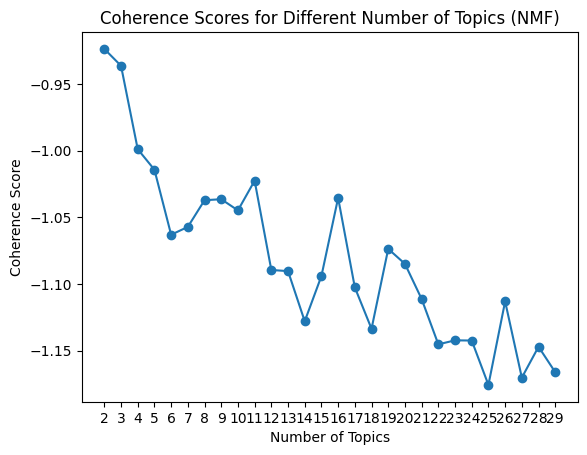

In [35]:
nmf_coherence_scores = []

# Iterate over different numbers of topics
for num_topics in num_topics_range:
    start_time = time.time()
    print(f"NMF: Calculating result for {num_topics} topics...")
    # Fit NMF model
    nmf_model = Nmf(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Compute coherence score
    coherence_model = CoherenceModel(model=nmf_model, texts=texts, corpus=corpus, coherence='u_mass')
    coherence_score = coherence_model.get_coherence()
    nmf_coherence_scores.append(coherence_score)

    end_time = time.time()
    print(f"Took {end_time - start_time:.2f} seconds.")

# Plot coherence scores
plt.plot(num_topics_range, nmf_coherence_scores, marker='o')
plt.title('Coherence Scores for Different Number of Topics (NMF)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_range)
plt.show()

In [52]:
nmf_model = Nmf(corpus=corpus, num_topics=25, id2word=dictionary, random_state=42)
nmf_model.print_topics()

[(24,
  '0.021*"water" + 0.013*"food" + 0.011*"security" + 0.010*"land" + 0.010*"price" + 0.009*"hawker" + 0.009*"property" + 0.007*"member" + 0.007*"interest" + 0.006*"think"'),
 (23,
  '0.024*"court" + 0.014*"case" + 0.011*"law" + 0.009*"section" + 0.009*"person" + 0.008*"offence" + 0.007*"party" + 0.006*"legal" + 0.006*"justice" + 0.005*"criminal"'),
 (15,
  '0.013*"foreign" + 0.013*"ma" + 0.011*"national" + 0.010*"interest" + 0.010*"financial" + 0.009*"president" + 0.008*"international" + 0.007*"property" + 0.006*"power" + 0.005*"asean"'),
 (20,
  '0.012*"service" + 0.008*"officer" + 0.008*"data" + 0.008*"online" + 0.008*"police" + 0.007*"information" + 0.006*"security" + 0.006*"offence" + 0.006*"measure" + 0.006*"individual"'),
 (2,
  '0.016*"law" + 0.013*"officer" + 0.012*"security" + 0.011*"drug" + 0.009*"legal" + 0.008*"international" + 0.008*"conflict" + 0.007*"israel" + 0.006*"foreign" + 0.006*"country"'),
 (13,
  '0.016*"transport" + 0.014*"vehicle" + 0.014*"ev" + 0.013*"roa

LDA: Calculating result for 2 topics...


Took 21.32 seconds.
LDA: Calculating result for 3 topics...


Took 24.98 seconds.
LDA: Calculating result for 4 topics...


Took 24.29 seconds.
LDA: Calculating result for 5 topics...


Took 26.29 seconds.
LDA: Calculating result for 6 topics...


Took 27.38 seconds.
LDA: Calculating result for 7 topics...


Took 28.01 seconds.
LDA: Calculating result for 8 topics...


Took 28.38 seconds.
LDA: Calculating result for 9 topics...


Took 31.79 seconds.
LDA: Calculating result for 10 topics...


Took 29.76 seconds.
LDA: Calculating result for 11 topics...


Took 30.55 seconds.
LDA: Calculating result for 12 topics...


Took 31.92 seconds.
LDA: Calculating result for 13 topics...


Took 31.24 seconds.
LDA: Calculating result for 14 topics...


Took 32.52 seconds.
LDA: Calculating result for 15 topics...


Took 33.61 seconds.
LDA: Calculating result for 16 topics...


Took 37.80 seconds.
LDA: Calculating result for 17 topics...


Took 33.62 seconds.
LDA: Calculating result for 18 topics...
Took 32.95 seconds.
LDA: Calculating result for 19 topics...


Took 34.31 seconds.
LDA: Calculating result for 20 topics...


Took 35.95 seconds.
LDA: Calculating result for 21 topics...
Took 34.44 seconds.
LDA: Calculating result for 22 topics...


Took 35.13 seconds.
LDA: Calculating result for 23 topics...


Took 36.35 seconds.
LDA: Calculating result for 24 topics...
Took 37.15 seconds.
LDA: Calculating result for 25 topics...


Took 38.91 seconds.
LDA: Calculating result for 26 topics...


Took 37.85 seconds.
LDA: Calculating result for 27 topics...


Took 38.76 seconds.
LDA: Calculating result for 28 topics...


Took 38.06 seconds.
LDA: Calculating result for 29 topics...


Took 39.33 seconds.


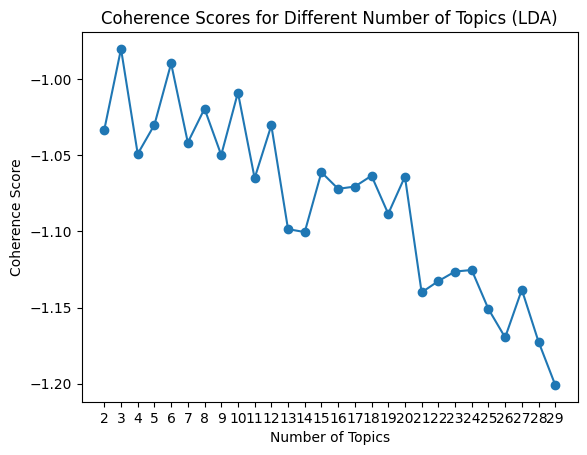

In [37]:
from gensim.models import LdaModel

lda_coherence_scores = []

# Iterate over different numbers of topics
for num_topics in num_topics_range:
    start_time = time.time()
    print(f"LDA: Calculating result for {num_topics} topics...")
    # Fit NMF model
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics,
                         id2word=dictionary, random_state=42)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='u_mass')
    coherence_score = coherence_model.get_coherence()
    lda_coherence_scores.append(coherence_score)

    end_time = time.time()
    print(f"Took {end_time - start_time:.2f} seconds.")

# Plot coherence scores
plt.plot(num_topics_range, lda_coherence_scores, marker='o')
plt.title('Coherence Scores for Different Number of Topics (LDA)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_range)
plt.show()

In [53]:
num_topics = 28

In [54]:
lda_model = LdaModel(corpus=corpus, num_topics=num_topics,
                         id2word=dictionary, random_state=42)

In [55]:
lda_model.print_topics()

[(22,
  '0.019*"employer" + 0.014*"work" + 0.014*"woman" + 0.013*"child" + 0.012*"employee" + 0.010*"parent" + 0.009*"mother" + 0.009*"employment" + 0.008*"workplace" + 0.006*"practice"'),
 (3,
  '0.029*"school" + 0.028*"student" + 0.016*"education" + 0.009*"programme" + 0.009*"learning" + 0.007*"moe" + 0.007*"teacher" + 0.006*"support" + 0.006*"skill" + 0.005*"university"'),
 (1,
  '0.014*"company" + 0.011*"industry" + 0.010*"sector" + 0.008*"smes" + 0.007*"technology" + 0.006*"business" + 0.005*"service" + 0.005*"economy" + 0.005*"energy" + 0.005*"growth"'),
 (5,
  '0.029*"food" + 0.017*"hawker" + 0.013*"waste" + 0.011*"centre" + 0.008*"nea" + 0.007*"water" + 0.005*"recycling" + 0.005*"environment" + 0.005*"plastic" + 0.004*"work"'),
 (24,
  '0.010*"information" + 0.009*"data" + 0.008*"service" + 0.007*"online" + 0.006*"financial" + 0.005*"security" + 0.005*"ma" + 0.004*"protection" + 0.004*"individual" + 0.004*"personal"'),
 (16,
  '0.026*"child" + 0.023*"family" + 0.014*"social" + 

In [56]:
from gensim.utils import simple_preprocess

def get_topic_distribution(text):

    tokens = text.split()
    bow_vector = dictionary.doc2bow(tokens)
    topic_distribution = lda_model.get_document_topics(bow_vector)

    return topic_distribution

# Apply the function to each row of the DataFrame
ct_df['topic_distribution'] = ct_df['speech_text'].apply(get_topic_distribution)

In [57]:
ct_df

,topic_id,speech_text,topic_distribution
0,2024-03-07-T-001,ask exercise power reinstate half hour questio...,"[(3, 0.08627256), (12, 0.65156686), (20, 0.255..."
1,2024-03-07-T-002,defence effort taken address mental health iss...,"[(6, 0.3854257), (15, 0.59979624), (26, 0.0125..."
2,2024-03-07-T-003,health planned capacity increase patient seeki...,"[(3, 0.28878564), (15, 0.30251354), (17, 0.255..."
3,2024-03-07-T-004,health active ageing centre set next five year...,"[(1, 0.10646378), (12, 0.32355765), (13, 0.066..."
4,2024-03-07-T-005,manpower view senior live mature estate whose ...,"[(0, 0.27716243), (10, 0.5268068), (17, 0.0317..."
...,...,...,...
17457,2012-09-10-T-067,education total amount partnership related fee...,"[(1, 0.2462365), (2, 0.023936993), (3, 0.67236..."
17458,2012-09-10-T-068,acting community development youth sport past ...,"[(0, 0.27469236), (8, 0.037617695), (13, 0.062..."
17459,2012-09-10-T-069,acting manpower year number employer warned fi...,"[(2, 0.17544635), (5, 0.024544291), (11, 0.315..."
17460,2012-09-10-T-070,acting manpower gathering feedback smes impact...,"[(1, 0.30354762), (19, 0.66824305), (24, 0.024..."


In [61]:
ct_df.iloc[2,1]

'health planned capacity increase patient seeking mental health specialist care imh ii alexandra hospital b step taken support necessary resource required alexandra hospital provide outpatient inpatient mental health specialist service including acute bed psychiatric care rehabilitation institute mental health imh recently refurbished acute psychiatric ward enhance inpatient care expanding capacity meet future demand support increase demand mental health service planning increase number psychiatrist increase number healthcare worker training psychology expand mental health service primary community setting support national mental health wellbeing strategy m nadia quick followup supplementary senior sharing training place learning opportunity think student interested pursue route could senior give little bit detail training opportunity trickle learning institution understand m nadia samdins training opportunity made within learning institution number institution already provide training

In [59]:
ct_df.iloc[2,2]

[(3, 0.28878564), (15, 0.30251354), (17, 0.25519702), (23, 0.14849898)]